# 人脸检测和关键点提取

这个笔记将实现一个简单的应用:

- 使用Haar级联检测器检测出图像中的所有人脸.
- 将这些人脸裁剪下来, 应用在`facial_keypoints.ipynb`中训练的CNN网络, 提取其中的关键点.
- 将这些关键点显示出来

其中, Haar检测器OpenCV已经提供了, 人脸关键点检测模型需要手动训练, 使用PyTorch完成.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import facial_keypoints_train as fk_train
import facial_keypoints_dataset as fk_dataset

import cv2

%matplotlib inline

## 选择图像

选择一张你喜欢的图像吧! 其中需要至少包含了一张人脸.

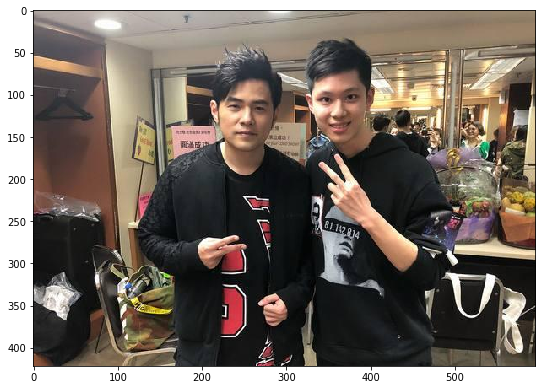

In [2]:
image_path = './jielun.jpeg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(9, 9))
plt.imshow(image)

## 检测图像中的所有人脸

使用`face_detection`中的代码即可实现人脸检测. 需要导入分类器模型.

在检测出人脸之后, 需要分别对这些人脸使用关键点检测模型.

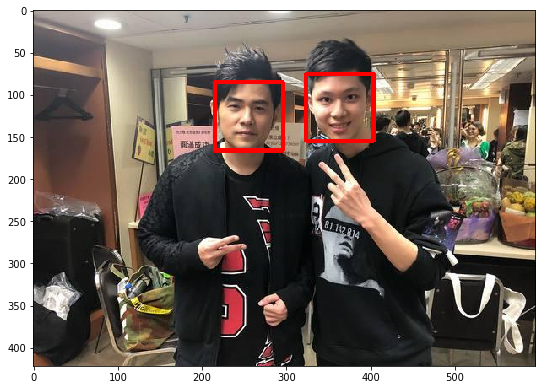

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(image, 1.2, 2)

image_detected = image.copy()

for (x, y, w, h) in faces:
    
    cv2.rectangle(image_detected, (x, y), (x + w, y + h), (255, 0, 0), 3)
    
plt.figure(figsize=(9, 9))

plt.imshow(image_detected)

## 加载已经训练的模型

在关键点检测之前, 需要加载已经训练好的模型. 你可以在笔记[facial_keypoints.ipynb](facial_keypoints.ipynb)中训练模型.

In [4]:
model = fk_train.load_model()
model.eval()

print(model)

FacialKpModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=7744, out_features=4000, bias=True)
  (fc2): Linear(in_features=4000, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## 图像预处理

模型接受的不是标准的RGB图像, 需要经过以下预处理才能提供给模型:

- 把图像转换为灰度图
- 把图像像素值归一化到\[0,1\]之间
- 把图像缩放到模型的输入尺寸(224, 224)
- 把numpy数组转换为tensor

以上步骤全部封装在dataset中了, 只需要调用`transform_image`即可.


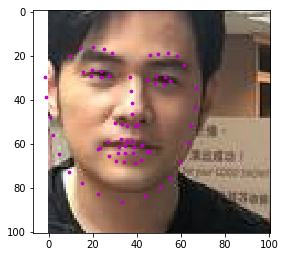

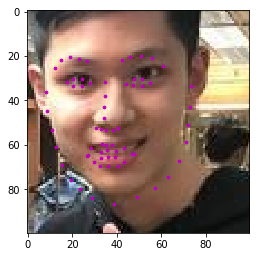

In [6]:
image_copy = np.copy(image)

for (x, y, w, h) in faces:
    
    roi = image_copy[y:y + h + 20, x:x + w + 20]
    
    model_input = fk_dataset.transform_image(roi)
    
    detected_kps = model(model_input)
    detected_kps = detected_kps.view(68, 2)
    detected_kps = detected_kps.data.numpy()
    
    detected_kps = (detected_kps * 50.0) + 100
    detected_kps = detected_kps * (roi.shape[1] / 224, roi.shape[0] / 224)
    
    plt.figure(figsize=(9, 9))
    plt.subplot(2, 1, 1)
    
    plt.imshow(roi)
    plt.scatter(detected_kps[:, 0], detected_kps[:, 1], s=30, marker='.', c='m')
    
    plt.show()
